---
# ***SETTINGS***
---

In [1]:
# SARA: montiamo a drive per collegarci alla cartella desiderata
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
# IMPORT LIBRARIES
import json
import os
import pandas as pd
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
import math
from re import X
import tensorflow as tf
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.layers import Flatten, GlobalAveragePooling2D, Multiply, Reshape, Dense
from tensorflow.keras.layers import UpSampling2D, Conv2D
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

tfk = tf.keras
tfkl = tf.keras.layers

import random
import numpy as np
seed = 4

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

---
# ***CONVERSIONE DEI FILE .JSON***
---

In [3]:
import os
import pandas as pd

# Specifica la directory del tuo file JSON
directory = '/content/gdrive/MyDrive/SAPIENS-project/DB_autoprodotto'

# Lista di nomi dei file JSON che iniziano con "esperimento_" e terminano con "_baseline.json"
file_names = [file for file in os.listdir(directory) if file.startswith('esperimento_') and file.endswith('_baseline.json')]

# Lista per memorizzare i DataFrame risultanti da ciascun file
dfs_list = []

# Loop attraverso i file
for nome_file_json in file_names:
    # Unisci il percorso della directory con il nome del file
    percorso_completo_baseline = os.path.join(directory, nome_file_json)

    # Carica il file JSON in un DataFrame Pandas
    dataframe = pd.read_json(percorso_completo_baseline)

    # Esegui le operazioni sul DataFrame (rimuovere la seconda riga, riformattare, ecc.)
    df = pd.DataFrame(dataframe, index=['pow', 'time'])
    df_excluded = df.loc[['pow']]

    new_row_names = df_excluded.columns[3:]
    df_reshaped = pd.melt(df_excluded[new_row_names], var_name='Column', value_name='Value')

    a = df_reshaped['Value'].tolist()
    df_result_baseline = pd.DataFrame(a, columns=[f'Value{i+1}' for i in range(25)])

    new_columns = ['AF3_Theta', 'AF3_Alpha', 'AF3_BetaL', 'AF3_BetaH', 'AF3_Gamma',
                   'T7_Theta', 'T7_Alpha', 'T7_BetaL', 'T7_BetaH', 'T7_Gamma',
                   'Pz_Theta', 'Pz_Alpha', 'Pz_BetaL', 'Pz_BetaH', 'Pz_Gamma',
                   'T8_Theta', 'T8_Alpha', 'T8_BetaL', 'T8_BetaH', 'T8_Gamma',
                   'AF4_Theta', 'AF4_Alpha', 'AF4_BetaL', 'AF4_BetaH', 'AF4_Gamma']

    df_result_baseline.columns = new_columns
    df_result_baseline['Phase'] = 'Baseline'

    # Aggiungi il DataFrame risultante alla lista
    dfs_list.append(df_result_baseline)

# Concatena tutti i DataFrame risultanti in un unico DataFrame
df_result_all = pd.concat(dfs_list, ignore_index=True)

# Salva il DataFrame risultante o esegui qualsiasi altra operazione necessaria
#df_result_all.to_csv(os.path.join(directory, 'output_totale.csv'), index=False)

In [4]:
df_result_all

,AF3_Theta,AF3_Alpha,AF3_BetaL,AF3_BetaH,AF3_Gamma,T7_Theta,T7_Alpha,T7_BetaL,T7_BetaH,T7_Gamma,...,T8_Alpha,T8_BetaL,T8_BetaH,T8_Gamma,AF4_Theta,AF4_Alpha,AF4_BetaL,AF4_BetaH,AF4_Gamma,Phase
0,12.005,1.669,0.582,0.965,0.474,0.736,1.712,0.917,0.743,0.709,...,0.971,1.013,1.463,1.295,12.096,1.612,0.762,0.824,0.531,Baseline
1,23.221,2.252,0.742,1.091,0.527,0.829,2.258,0.742,0.811,0.809,...,1.141,1.063,1.751,1.436,23.744,2.523,0.822,0.909,0.567,Baseline
2,40.312,3.163,0.940,1.165,0.573,1.006,2.724,0.617,0.906,0.907,...,1.300,1.124,2.090,1.583,40.853,3.772,0.926,0.954,0.595,Baseline
3,59.273,4.094,1.156,1.186,0.598,1.190,2.934,0.542,1.052,0.980,...,1.372,1.153,2.389,1.684,58.976,4.981,1.084,0.954,0.613,Baseline
4,74.226,4.715,1.365,1.169,0.600,1.306,2.810,0.503,1.252,1.012,...,1.334,1.128,2.548,1.697,72.127,5.722,1.275,0.919,0.621,Baseline
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2397,1.775,3.989,3.334,4.503,7.240,8.069,5.258,3.556,4.139,6.097,...,4.000,6.511,8.280,9.366,2.927,5.942,3.532,5.938,7.283,Baseline
2398,1.659,4.771,2.651,4.363,7.214,9.046,6.752,3.720,4.560,6.323,...,5.647,4.842,7.710,8.961,3.086,6.382,2.948,6.263,7.317,Baseline
2399,1.633,5.325,2.356,4.267,7.179,9.445,7.943,4.142,5.081,6.550,...,7.239,3.766,7.396,8.566,3.140,6.423,2.706,6.658,7.418,Baseline
2400,1.623,5.514,2.453,4.264,7.099,9.278,8.493,4.650,5.609,6.697,...,8.323,3.185,7.426,8.295,3.064,6.096,2.767,7.105,7.514,Baseline


In [5]:
import os
import pandas as pd

# Specifica la directory del tuo file JSON
directory = '/content/gdrive/MyDrive/SAPIENS-project/DB_autoprodotto'

# Lista di nomi dei file JSON che iniziano con "esperimento_" e terminano con "_baseline.json"
file_names = [file for file in os.listdir(directory) if file.startswith('esperimento_') and file.endswith('_sudoku.json')]

# Lista per memorizzare i DataFrame risultanti da ciascun file
dfs_list = []

# Loop attraverso i file
for nome_file_json in file_names:
    # Unisci il percorso della directory con il nome del file
    percorso_completo_sudoku = os.path.join(directory, nome_file_json)

    # Carica il file JSON in un DataFrame Pandas
    dataframe = pd.read_json(percorso_completo_baseline)

    # Esegui le operazioni sul DataFrame (rimuovere la seconda riga, riformattare, ecc.)
    df = pd.DataFrame(dataframe, index=['pow', 'time'])
    df_excluded = df.loc[['pow']]

    new_row_names = df_excluded.columns[3:]
    df_reshaped = pd.melt(df_excluded[new_row_names], var_name='Column', value_name='Value')

    a = df_reshaped['Value'].tolist()
    df_result_sudoku = pd.DataFrame(a, columns=[f'Value{i+1}' for i in range(25)])

    new_columns = ['AF3_Theta', 'AF3_Alpha', 'AF3_BetaL', 'AF3_BetaH', 'AF3_Gamma',
                   'T7_Theta', 'T7_Alpha', 'T7_BetaL', 'T7_BetaH', 'T7_Gamma',
                   'Pz_Theta', 'Pz_Alpha', 'Pz_BetaL', 'Pz_BetaH', 'Pz_Gamma',
                   'T8_Theta', 'T8_Alpha', 'T8_BetaL', 'T8_BetaH', 'T8_Gamma',
                   'AF4_Theta', 'AF4_Alpha', 'AF4_BetaL', 'AF4_BetaH', 'AF4_Gamma']

    df_result_sudoku.columns = new_columns
    df_result_sudoku['Phase'] = 'Sudoku'

    # Aggiungi il DataFrame risultante alla lista
    dfs_list.append(df_result_sudoku)

# Concatena tutti i DataFrame risultanti in un unico DataFrame
df_result_all2 = pd.concat(dfs_list, ignore_index=True)

# Salva il DataFrame risultante o esegui qualsiasi altra operazione necessaria
#df_result_all.to_csv(os.path.join(directory, 'output_totale.csv'), index=False)

In [6]:
df_result_all2

,AF3_Theta,AF3_Alpha,AF3_BetaL,AF3_BetaH,AF3_Gamma,T7_Theta,T7_Alpha,T7_BetaL,T7_BetaH,T7_Gamma,...,T8_Alpha,T8_BetaL,T8_BetaH,T8_Gamma,AF4_Theta,AF4_Alpha,AF4_BetaL,AF4_BetaH,AF4_Gamma,Phase
0,4.928,3.408,2.549,7.422,2.927,3.491,0.839,1.113,6.914,2.663,...,8.751,5.195,8.041,3.105,7.192,3.576,3.560,8.071,3.827,Sudoku
1,5.317,3.337,3.080,7.639,3.099,3.851,0.780,1.432,6.771,2.900,...,9.542,5.410,7.772,3.119,7.414,3.374,3.571,8.383,3.946,Sudoku
2,5.409,3.274,3.489,8.268,3.562,3.970,0.712,1.790,6.972,3.388,...,9.581,5.335,8.262,3.904,7.261,3.302,3.604,9.212,4.512,Sudoku
3,5.155,3.188,3.600,8.994,4.243,3.779,0.691,2.097,7.321,4.033,...,9.092,4.939,9.265,5.358,6.702,3.285,3.569,10.244,5.433,Sudoku
4,4.637,3.093,3.368,9.385,5.055,3.385,0.781,2.311,7.520,4.757,...,8.497,4.372,10.257,7.192,5.815,3.268,3.384,10.999,6.532,Sudoku
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2400,1.775,3.989,3.334,4.503,7.240,8.069,5.258,3.556,4.139,6.097,...,4.000,6.511,8.280,9.366,2.927,5.942,3.532,5.938,7.283,Sudoku
2401,1.659,4.771,2.651,4.363,7.214,9.046,6.752,3.720,4.560,6.323,...,5.647,4.842,7.710,8.961,3.086,6.382,2.948,6.263,7.317,Sudoku
2402,1.633,5.325,2.356,4.267,7.179,9.445,7.943,4.142,5.081,6.550,...,7.239,3.766,7.396,8.566,3.140,6.423,2.706,6.658,7.418,Sudoku
2403,1.623,5.514,2.453,4.264,7.099,9.278,8.493,4.650,5.609,6.697,...,8.323,3.185,7.426,8.295,3.064,6.096,2.767,7.105,7.514,Sudoku


In [7]:
df_concatenated = pd.concat([df_result_all, df_result_all2], axis=0)
df_concatenated

,AF3_Theta,AF3_Alpha,AF3_BetaL,AF3_BetaH,AF3_Gamma,T7_Theta,T7_Alpha,T7_BetaL,T7_BetaH,T7_Gamma,...,T8_Alpha,T8_BetaL,T8_BetaH,T8_Gamma,AF4_Theta,AF4_Alpha,AF4_BetaL,AF4_BetaH,AF4_Gamma,Phase
0,12.005,1.669,0.582,0.965,0.474,0.736,1.712,0.917,0.743,0.709,...,0.971,1.013,1.463,1.295,12.096,1.612,0.762,0.824,0.531,Baseline
1,23.221,2.252,0.742,1.091,0.527,0.829,2.258,0.742,0.811,0.809,...,1.141,1.063,1.751,1.436,23.744,2.523,0.822,0.909,0.567,Baseline
2,40.312,3.163,0.940,1.165,0.573,1.006,2.724,0.617,0.906,0.907,...,1.300,1.124,2.090,1.583,40.853,3.772,0.926,0.954,0.595,Baseline
3,59.273,4.094,1.156,1.186,0.598,1.190,2.934,0.542,1.052,0.980,...,1.372,1.153,2.389,1.684,58.976,4.981,1.084,0.954,0.613,Baseline
4,74.226,4.715,1.365,1.169,0.600,1.306,2.810,0.503,1.252,1.012,...,1.334,1.128,2.548,1.697,72.127,5.722,1.275,0.919,0.621,Baseline
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2400,1.775,3.989,3.334,4.503,7.240,8.069,5.258,3.556,4.139,6.097,...,4.000,6.511,8.280,9.366,2.927,5.942,3.532,5.938,7.283,Sudoku
2401,1.659,4.771,2.651,4.363,7.214,9.046,6.752,3.720,4.560,6.323,...,5.647,4.842,7.710,8.961,3.086,6.382,2.948,6.263,7.317,Sudoku
2402,1.633,5.325,2.356,4.267,7.179,9.445,7.943,4.142,5.081,6.550,...,7.239,3.766,7.396,8.566,3.140,6.423,2.706,6.658,7.418,Sudoku
2403,1.623,5.514,2.453,4.264,7.099,9.278,8.493,4.650,5.609,6.697,...,8.323,3.185,7.426,8.295,3.064,6.096,2.767,7.105,7.514,Sudoku


In [8]:
# MISSING VALUES CHECK
df_concatenated.isna().any()

AF3_Theta    False
AF3_Alpha    False
AF3_BetaL    False
AF3_BetaH    False
AF3_Gamma    False
T7_Theta     False
T7_Alpha     False
T7_BetaL     False
T7_BetaH     False
T7_Gamma     False
Pz_Theta     False
Pz_Alpha     False
Pz_BetaL     False
Pz_BetaH     False
Pz_Gamma     False
T8_Theta     False
T8_Alpha     False
T8_BetaL     False
T8_BetaH     False
T8_Gamma     False
AF4_Theta    False
AF4_Alpha    False
AF4_BetaL    False
AF4_BetaH    False
AF4_Gamma    False
Phase        False
dtype: bool

In [9]:
# Use the astype method to convert columns to float
columns_to_convert = [
    'AF3_Theta', 'AF3_Alpha', 'AF3_BetaL', 'AF3_BetaH', 'AF3_Gamma',
    'T7_Theta', 'T7_Alpha', 'T7_BetaL', 'T7_BetaH', 'T7_Gamma',
    'Pz_Theta', 'Pz_Alpha', 'Pz_BetaL', 'Pz_BetaH', 'Pz_Gamma',
    'T8_Theta', 'T8_Alpha', 'T8_BetaL', 'T8_BetaH', 'T8_Gamma',
    'AF4_Theta', 'AF4_Alpha', 'AF4_BetaL', 'AF4_BetaH', 'AF4_Gamma'
]

# total df
df_concatenated[columns_to_convert] = df_concatenated[columns_to_convert].astype(float)

# all dfs
#for i in dfs_list:
#  i[columns_to_convert] = i[columns_to_convert].astype(float)

In [10]:
print(df_concatenated.dtypes)

AF3_Theta    float64
AF3_Alpha    float64
AF3_BetaL    float64
AF3_BetaH    float64
AF3_Gamma    float64
T7_Theta     float64
T7_Alpha     float64
T7_BetaL     float64
T7_BetaH     float64
T7_Gamma     float64
Pz_Theta     float64
Pz_Alpha     float64
Pz_BetaL     float64
Pz_BetaH     float64
Pz_Gamma     float64
T8_Theta     float64
T8_Alpha     float64
T8_BetaL     float64
T8_BetaH     float64
T8_Gamma     float64
AF4_Theta    float64
AF4_Alpha    float64
AF4_BetaL    float64
AF4_BetaH    float64
AF4_Gamma    float64
Phase         object
dtype: object


In [11]:
# I need only data, not phase names
x = df_concatenated
z = x.drop(columns = 'Phase')

# Conversion to numpy array
xnew = z.to_numpy()
# Let's check the shape
print(xnew.shape)

(4807, 25)


In [12]:
# Labels: I need a one-hot encoder. I realize the most basic (and stupid) one.
# I know there also the tfkl function "to_categorical()" but I gives me an error
# and now I don't have time to solve it
y = df_concatenated['Phase']

labels = []
for i in y:
  if i == "Baseline":
    labels.append(1)
  elif i == "Sudoku":
    labels.append(0)

# conversion to array and shape check
labels = np.asarray(labels)
print("Original labels: ", labels.shape)

cat_labels = to_categorical(labels)
print("Categorical labels: ", cat_labels.shape)

Original labels:  (4807,)
Categorical labels:  (4807, 2)


In [13]:
# SPLIT DATA INTO TRAIN AND TEST SET
X_train, X_test, y_train, y_test = train_test_split(xnew,
                                                    cat_labels,
                                                    test_size =0.20,
                                                    random_state= seed,
                                                    shuffle=True)   #fix random seed for replicability

# Now split again into train and validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.20, random_state=seed, shuffle=True)

print( "X train shape:", X_train.shape, "X test shape:", X_test.shape, "X val shape:", X_val.shape, "y train shape:", y_train.shape, "y test shape:", y_test.shape, "y val shape:", y_val.shape)

X train shape: (3076, 25) X test shape: (962, 25) X val shape: (769, 25) y train shape: (3076, 2) y test shape: (962, 2) y val shape: (769, 2)


In [14]:
# While y_train, y_val ecc.. are categorical, I need train_labels which is not hot-encoded version yet.
y_train_len = len(y_train)
y_val_len = len(y_val)

train_labels = labels[:y_train_len]
val_labels = labels[:y_val_len]
print(len(train_labels))
print(len(val_labels))

3076
769


In [15]:
# CLASS BALANCING
weights = compute_class_weight('balanced', classes=[0, 1], y=train_labels)

# Creare un dizionario di pesi delle classi
weights_dict = {classe: peso for classe, peso in zip([0, 1], weights)}

# Stampa dei pesi delle classi
print("Classes weights:", weights_dict)

Classes weights: {0: 2.2818991097922847, 1: 0.6402997502081599}


In [16]:
# my model
def CNN1D_classifier(input_shape, label):
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    cnn = tfkl.Conv1D(512,3,padding='same',activation='relu', name = "prova")(input_layer)
    cnn = tfkl.MaxPooling1D()(cnn)
    cnn = tfkl.Conv1D(512,3,padding='same',activation='relu')(cnn)
    gap = tfkl.GlobalAveragePooling1D()(cnn)
    dropout = tfkl.Dropout(.3, seed=seed)(gap)

    classifier = tfkl.Dense(1024, activation='relu')(dropout)
    dropout2 = tfkl.Dropout(.3, seed=seed)(classifier)
    output_layer = tfkl.Dense(2, activation='softmax')(dropout2)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    opt = tf.keras.optimizers.Adam(
      learning_rate = 2e-4,
      beta_1=0.9,
      beta_2=0.999,
      epsilon=1e-08,
      amsgrad=False,
      name="Adam",
    )
    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')
    #model.compile(loss=tfk.losses.BinaryCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')


    # Return the model
    return model

model = CNN1D_classifier((25, 1), labels)

In [17]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = 32,
    class_weight = weights_dict,
    epochs = 32,
    validation_data=(X_test, y_test),
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=20, restore_best_weights=True)] # I should recompile with a higher patience
).history

Epoch 1/32
97/97 [==============================] - 12s 113ms/step - loss: 0.5459 - accuracy: 0.7006 - val_loss: 0.5047 - val_accuracy: 0.8358
Epoch 2/32
97/97 [==============================] - 9s 90ms/step - loss: 0.3495 - accuracy: 0.8680 - val_loss: 0.4735 - val_accuracy: 0.8420
Epoch 3/32
97/97 [==============================] - 10s 107ms/step - loss: 0.3005 - accuracy: 0.8849 - val_loss: 0.3918 - val_accuracy: 0.8732
Epoch 4/32
97/97 [==============================] - 10s 104ms/step - loss: 0.2881 - accuracy: 0.8878 - val_loss: 0.3724 - val_accuracy: 0.8794
Epoch 5/32
97/97 [==============================] - 9s 91ms/step - loss: 0.2882 - accuracy: 0.8862 - val_loss: 0.3741 - val_accuracy: 0.8784
Epoch 6/32
97/97 [==============================] - 11s 111ms/step - loss: 0.2719 - accuracy: 0.8917 - val_loss: 0.3793 - val_accuracy: 0.8701
Epoch 7/32
97/97 [==============================] - 8s 85ms/step - loss: 0.2669 - accuracy: 0.8953 - val_loss: 0.4239 - val_accuracy: 0.8805
Epoch

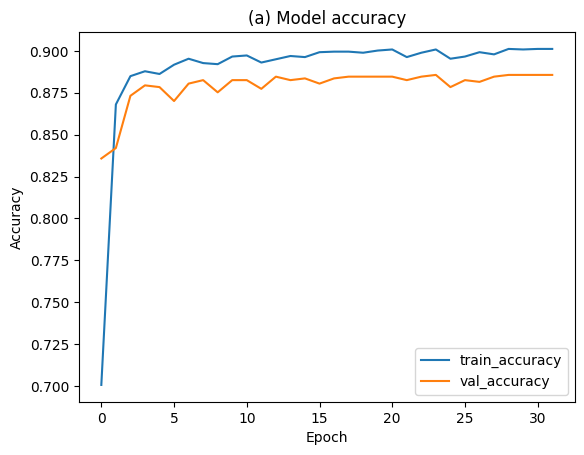

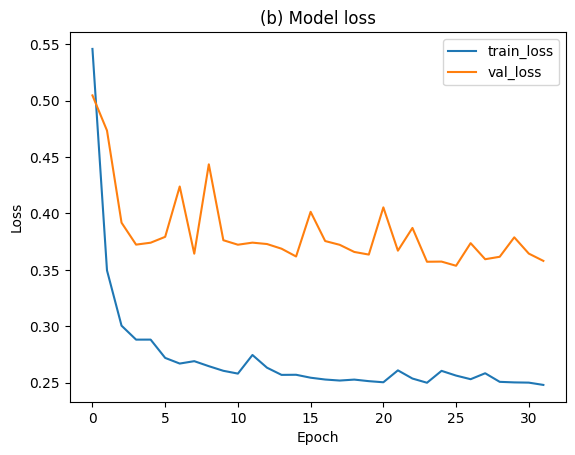

In [18]:
# Plot training & validation accuracy values
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.legend(['train_accuracy', 'val_accuracy'])
plt.title('(a) Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

# Plot training & validation loss values
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.legend(['train_loss', 'val_loss'])
plt.title('(b) Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

In [19]:
#X_test = X_test.astype(float)
from time import time

startTime = time()
y_pred = model.predict(X_val)
correct_predictions = 0
finalTime = time()

correct_predictions = np.sum(np.argmax(y_pred, axis=1) == np.argmax(y_val, axis=1))
total_predictions = len(y_pred)
accuracy_percentage = (correct_predictions / total_predictions) * 100
print(f"Accuracy: {accuracy_percentage:.2f}%\tTotal time for {total_predictions} predictions: {(finalTime-startTime):.2f} seconds")

25/25 [==============================] - 0s 14ms/step
Accuracy: 91.29%	Total time for 769 predictions: 0.54 seconds


---
# ***RIFERIMENTO A BASELINE***
---

In [20]:
# Supponiamo che il tuo DataFrame sia chiamato df
# e la colonna del label sia chiamata 'Label'

x3 = x.copy()

# Lista di valori per il confronto
fasi_di_interesse = ["Baseline"]

# Seleziona solo le righe con le fasi di interesse
dati_relax = x3[x3['Phase'].str.lower().isin([fase.lower() for fase in fasi_di_interesse])]

# Calcola la media e la deviazione standard per le colonne "relax"
mean_relax = dati_relax.mean()
std_relax = dati_relax.std()

# Applica la normalizzazione alle colonne "focus"
nuove_fasi = ['Sudoku', 'sudoku']
for fase in nuove_fasi:
    dati_fase = x3[x3['Phase'].str.lower() == fase.lower()]
    colonne_numeriche = dati_fase.select_dtypes(include='number').columns
    x3[colonne_numeriche] = (x3[colonne_numeriche] - mean_relax) / std_relax

z3 = x3.drop(columns = 'Phase')

# Conversion to numpy array
xnew3 = z3.to_numpy()
# Let's check the shape
print(xnew3.shape)

(4807, 25)


<ipython-input-20-0853d8530bbc>:13: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  mean_relax = dati_relax.mean()
<ipython-input-20-0853d8530bbc>:14: FutureWarning: The default value of numeric_only in DataFrame.std is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  std_relax = dati_relax.std()


In [21]:
# SPLIT DATA INTO TRAIN AND TEST SET
X_train3, X_test3, y_train3, y_test3 = train_test_split(xnew3, cat_labels,
                                                    test_size =0.20,
                                                    random_state= seed,
                                                    shuffle = True)   #fix random seed for replicability

# Now split again into train and validation
X_train3, X_val3, y_train3, y_val3 = train_test_split(X_train3, y_train3, test_size=0.20, random_state=seed, shuffle=True)

print( "X train shape:", X_train3.shape, "X test shape:", X_test3.shape, "X val shape:", X_val3.shape, "y train shape:", y_train3.shape, "y test shape:", y_test3.shape, "y val shape:", y_val3.shape)

X train shape: (3076, 25) X test shape: (962, 25) X val shape: (769, 25) y train shape: (3076, 2) y test shape: (962, 2) y val shape: (769, 2)


In [22]:
# While y_train, y_val ecc.. are categorical, I need train_labels which is not hot-encoded version yet.
y_train_len3 = len(y_train3)
y_val_len3 = len(y_val3)

train_labels3 = labels[:y_train_len3]
val_labels3 = labels[:y_val_len3]
print(len(train_labels))
print(len(val_labels))

3076
769


In [23]:
# Train the model
history = model.fit(
    x = X_train3,
    y = y_train3,
    batch_size = 32,
   class_weight = weights_dict,
    epochs = 32,
    validation_data=(X_test3, y_test3),
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=20, restore_best_weights=True)] # I should recompile with a higher patience
).history

Epoch 1/32
97/97 [==============================] - 11s 113ms/step - loss: 11.4971 - accuracy: 0.5062 - val_loss: 0.6482 - val_accuracy: 0.5000
Epoch 2/32
97/97 [==============================] - 8s 86ms/step - loss: 0.5997 - accuracy: 0.6769 - val_loss: 0.7893 - val_accuracy: 0.6819
Epoch 3/32
97/97 [==============================] - 11s 112ms/step - loss: 0.4579 - accuracy: 0.7819 - val_loss: 0.5957 - val_accuracy: 0.7921
Epoch 4/32
97/97 [==============================] - 9s 94ms/step - loss: 0.4119 - accuracy: 0.8053 - val_loss: 0.4936 - val_accuracy: 0.8087
Epoch 5/32
97/97 [==============================] - 10s 103ms/step - loss: 0.3910 - accuracy: 0.8270 - val_loss: 0.4361 - val_accuracy: 0.8212
Epoch 6/32
97/97 [==============================] - 11s 109ms/step - loss: 0.3634 - accuracy: 0.8407 - val_loss: 0.4459 - val_accuracy: 0.8326
Epoch 7/32
97/97 [==============================] - 9s 90ms/step - loss: 0.3486 - accuracy: 0.8466 - val_loss: 0.4342 - val_accuracy: 0.8410
Epoc

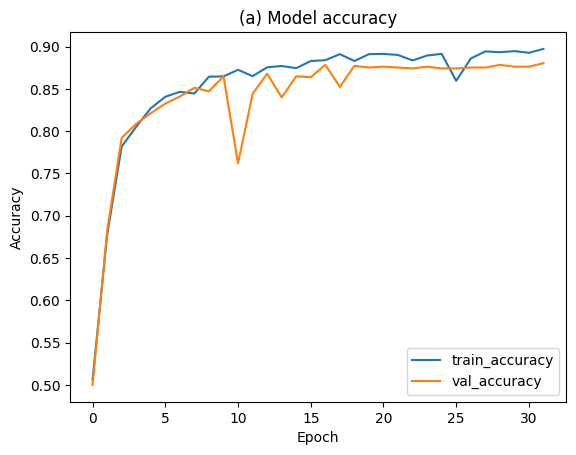

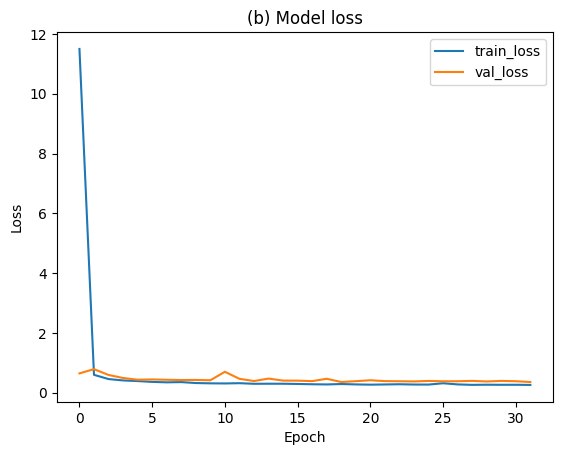

In [24]:
# Plot training & validation accuracy values
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.legend(['train_accuracy', 'val_accuracy'])
plt.title('(a) Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

# Plot training & validation loss values
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.legend(['train_loss', 'val_loss'])
plt.title('(b) Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

In [25]:
#X_test = X_test.astype(float)
from time import time

startTime = time()
y_pred3 = model.predict(X_val3)
correct_predictions = 0
finalTime = time()

correct_predictions = np.sum(np.argmax(y_pred3, axis=1) == np.argmax(y_val3, axis=1))
total_predictions = len(y_pred3)
accuracy_percentage = (correct_predictions / total_predictions) * 100
print(f"Accuracy: {accuracy_percentage:.2f}%\tTotal time for {total_predictions} predictions: {(finalTime-startTime):.2f} seconds")

25/25 [==============================] - 0s 14ms/step
Accuracy: 91.03%	Total time for 769 predictions: 0.43 seconds


---
# ***KNN + ADABOOST***
---

In [26]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier

# Crea il classificatore KNN
knn_classifier = KNeighborsClassifier(n_neighbors=5)

# Crea il classificatore DecisionTreeClassifier come classificatore base per AdaBoost
base_classifier = DecisionTreeClassifier(max_depth=1)  # Puoi personalizzare max_depth a seconda delle tue esigenze

# Crea il classificatore AdaBoost con DecisionTreeClassifier come classificatore base
adaboost_classifier = AdaBoostClassifier(base_estimator=base_classifier, n_estimators=50, random_state=42)


# Addestra il modello
adaboost_classifier.fit(X_train, train_labels)

#X_test = X_test.astype(float)
from time import time

startTime = time()
y_pred_ad = model.predict(X_val)
correct_predictions = 0
finalTime = time()

correct_predictions = np.sum(np.argmax(y_pred_ad, axis=1) == np.argmax(y_val, axis=1))
total_predictions = len(y_pred_ad)
accuracy_percentage = (correct_predictions / total_predictions) * 100
print(f"Accuracy: {accuracy_percentage:.2f}%\tTotal time for {total_predictions} predictions: {(finalTime-startTime):.2f} seconds")

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


25/25 [==============================] - 0s 14ms/step
Accuracy: 47.72%	Total time for 769 predictions: 0.43 seconds


In [27]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier

# Crea il classificatore KNN
knn_classifier = KNeighborsClassifier(n_neighbors=5)

# Crea il classificatore DecisionTreeClassifier come classificatore base per AdaBoost
base_classifier = DecisionTreeClassifier(max_depth=1)  # Puoi personalizzare max_depth a seconda delle tue esigenze

# Crea il classificatore AdaBoost con DecisionTreeClassifier come classificatore base
adaboost_classifier = AdaBoostClassifier(base_estimator=base_classifier, n_estimators=50, random_state=42)


# Addestra il modello
adaboost_classifier.fit(X_train3, train_labels3)

#X_test = X_test.astype(float)
from time import time

startTime = time()
y_pred_ad3 = model.predict(X_val3)
correct_predictions = 0
finalTime = time()

correct_predictions = np.sum(np.argmax(y_pred_ad3, axis=1) == np.argmax(y_val3, axis=1))
total_predictions = len(y_pred_ad3)
accuracy_percentage = (correct_predictions / total_predictions) * 100
print(f"Accuracy: {accuracy_percentage:.2f}%\tTotal time for {total_predictions} predictions: {(finalTime-startTime):.2f} seconds")

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


25/25 [==============================] - 0s 14ms/step
Accuracy: 91.03%	Total time for 769 predictions: 0.43 seconds


---
# ***DECISION TREE***
---

In [28]:
model_dt = DecisionTreeClassifier(criterion='gini', max_depth=9, min_samples_leaf=2, min_samples_split=6)
model_dt.fit(X_train, y_train)
startTime = time()
y_pred_dt = model_dt.predict(X_val)
correct_predictions = 0
finalTime = time()

correct_predictions = np.sum(np.argmax(y_pred_dt, axis=1) == np.argmax(y_val, axis=1))
total_predictions = len(y_pred_dt)
accuracy_percentage = (correct_predictions / total_predictions) * 100
print(f"Accuracy: {accuracy_percentage:.2f}%\tTotal time for {total_predictions} predictions: {(finalTime-startTime):.2f} seconds")

Accuracy: 91.29%	Total time for 769 predictions: 0.00 seconds


In [29]:
model_dt = DecisionTreeClassifier(criterion='gini', max_depth=9, min_samples_leaf=2, min_samples_split=6)
model_dt.fit(X_train3, y_train3)
startTime = time()
y_pred_dt3 = model_dt.predict(X_val3)
correct_predictions = 0
finalTime = time()

correct_predictions = np.sum(np.argmax(y_pred_dt3, axis=1) == np.argmax(y_val3, axis=1))
total_predictions = len(y_pred_dt3)
accuracy_percentage = (correct_predictions / total_predictions) * 100
print(f"Accuracy: {accuracy_percentage:.2f}%\tTotal time for {total_predictions} predictions: {(finalTime-startTime):.2f} seconds")

Accuracy: 91.29%	Total time for 769 predictions: 0.00 seconds


---
# ***RANDOM FOREST***
---

In [30]:
from sklearn.ensemble import RandomForestClassifier
model_rf = RandomForestClassifier(criterion='gini', max_depth=9, min_samples_leaf=2, min_samples_split=5, n_estimators=100)
model_rf.fit(X_train, y_train)
startTime = time()
y_pred_rf = model_rf.predict(X_val)
correct_predictions = 0
finalTime = time()

correct_predictions = np.sum(np.argmax(y_pred_rf, axis=1) == np.argmax(y_val, axis=1))
total_predictions = len(y_pred_rf)
accuracy_percentage = (correct_predictions / total_predictions) * 100
print(f"Accuracy: {accuracy_percentage:.2f}%\tTotal time for {total_predictions} predictions: {(finalTime-startTime):.2f} seconds")

Accuracy: 91.29%	Total time for 769 predictions: 0.02 seconds


In [31]:
from sklearn.ensemble import RandomForestClassifier
model_rf = RandomForestClassifier(criterion='gini', max_depth=9, min_samples_leaf=2, min_samples_split=5, n_estimators=100)
model_rf.fit(X_train3, y_train3)
startTime = time()
y_pred_rf3 = model_rf.predict(X_val3)
correct_predictions = 0
finalTime = time()

correct_predictions = np.sum(np.argmax(y_pred_rf3, axis=1) == np.argmax(y_val3, axis=1))
total_predictions = len(y_pred_rf3)
accuracy_percentage = (correct_predictions / total_predictions) * 100
print(f"Accuracy: {accuracy_percentage:.2f}%\tTotal time for {total_predictions} predictions: {(finalTime-startTime):.2f} seconds")

Accuracy: 91.29%	Total time for 769 predictions: 0.03 seconds


---
# ***SUPPORT VECTOR MACHINE***
---

In [32]:
from sklearn.svm import SVC
model_svc = SVC(C=1, degree= 2, gamma= 1, kernel='rbf',probability=True)
model_svc.fit(X_train, train_labels)
startTime = time()
y_pred_sv = model_svc.predict(X_val)
correct_predictions = 0
finalTime = time()
#print(y_pred_sv)

correct_predictions = np.sum(y_pred_sv == val_labels)
total_predictions = len(y_pred_sv)
accuracy_percentage = (correct_predictions / total_predictions) * 100
print(f"Accuracy: {accuracy_percentage:.2f}%\tTotal time for {total_predictions} predictions: {(finalTime-startTime):.2f} seconds")

Accuracy: 95.19%	Total time for 769 predictions: 0.14 seconds


In [33]:
from sklearn.svm import SVC
model_svc = SVC(C=1, degree= 2, gamma= 1, kernel='rbf',probability=True)
model_svc.fit(X_train, train_labels)
startTime = time()
y_pred_sv2 = model_svc.predict(X_val)
correct_predictions = 0
finalTime = time()
y_pred_sv2 = to_categorical(y_pred_sv2)
#print(y_pred_sv2)

correct_predictions = np.sum(np.argmax(y_pred_sv2, axis =1) == np.argmax(y_val, axis=1))
total_predictions = len(y_pred_sv)
accuracy_percentage = (correct_predictions / total_predictions) * 100
print(f"Accuracy: {accuracy_percentage:.2f}%\tTotal time for {total_predictions} predictions: {(finalTime-startTime):.2f} seconds")

Accuracy: 50.98%	Total time for 769 predictions: 0.21 seconds


---
# ***ROBA VECCHIA***
---

In [34]:
# Specifica la directory del tuo file JSON
directory = '/content/gdrive/MyDrive/SAPIENS-project/DB_autoprodotto'
# Specifica il nome del tuo file JSON
#nome_file_json = 'esperimento_0008_baseline.json'

# Unisci il percorso della directory con il nome del file
percorso_completo_baseline = os.path.join(directory, 'esperimento_0008_baseline.json')
# Carica il file JSON in un DataFrame Pandas
dataframe = pd.read_json(percorso_completo_baseline)

df = pd.DataFrame(dataframe, index=['pow', 'time'])
# Seleziona solo la prima riga
df_excluded = df.loc[['pow']]

new_row_names = df_excluded.columns[3:]
# Riformatta il DataFrame utilizzando pd.melt
df_reshaped = pd.melt(df_excluded[new_row_names], var_name='Column', value_name='Value')

a = df_reshaped['Value'].tolist()
df_result_baseline = pd.DataFrame(a, columns=[f'Value{i+1}' for i in range(25)])

new_columns = ['AF3_Theta', 'AF3_Alpha', 'AF3_BetaL', 'AF3_BetaH', 'AF3_Gamma',
           'T7_Theta', 'T7_Alpha', 'T7_BetaL', 'T7_BetaH', 'T7_Gamma',
           'Pz_Theta', 'Pz_Alpha', 'Pz_BetaL', 'Pz_BetaH', 'Pz_Gamma',
           'T8_Theta', 'T8_Alpha', 'T8_BetaL', 'T8_BetaH', 'T8_Gamma',
           'AF4_Theta', 'AF4_Alpha', 'AF4_BetaL', 'AF4_BetaH', 'AF4_Gamma']
df_result_baseline.columns = new_columns
df_result_baseline['Phase'] = 'Baseline'
df_result_baseline

,AF3_Theta,AF3_Alpha,AF3_BetaL,AF3_BetaH,AF3_Gamma,T7_Theta,T7_Alpha,T7_BetaL,T7_BetaH,T7_Gamma,...,T8_Alpha,T8_BetaL,T8_BetaH,T8_Gamma,AF4_Theta,AF4_Alpha,AF4_BetaL,AF4_BetaH,AF4_Gamma,Phase
0,12.005,1.669,0.582,0.965,0.474,0.736,1.712,0.917,0.743,0.709,...,0.971,1.013,1.463,1.295,12.096,1.612,0.762,0.824,0.531,Baseline
1,23.221,2.252,0.742,1.091,0.527,0.829,2.258,0.742,0.811,0.809,...,1.141,1.063,1.751,1.436,23.744,2.523,0.822,0.909,0.567,Baseline
2,40.312,3.163,0.940,1.165,0.573,1.006,2.724,0.617,0.906,0.907,...,1.300,1.124,2.090,1.583,40.853,3.772,0.926,0.954,0.595,Baseline
3,59.273,4.094,1.156,1.186,0.598,1.190,2.934,0.542,1.052,0.980,...,1.372,1.153,2.389,1.684,58.976,4.981,1.084,0.954,0.613,Baseline
4,74.226,4.715,1.365,1.169,0.600,1.306,2.810,0.503,1.252,1.012,...,1.334,1.128,2.548,1.697,72.127,5.722,1.275,0.919,0.621,Baseline
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
475,23.705,2.291,1.011,0.701,1.357,1.860,0.737,0.416,0.755,1.723,...,1.661,0.353,0.646,1.701,25.170,1.864,0.945,1.021,1.480,Baseline
476,15.213,1.674,0.867,0.587,1.251,1.555,0.994,0.443,0.706,1.602,...,1.468,0.316,0.628,1.571,16.987,1.186,0.756,0.934,1.397,Baseline
477,8.432,1.248,0.733,0.516,1.170,1.308,1.267,0.451,0.653,1.490,...,1.337,0.274,0.658,1.392,10.400,0.805,0.577,0.855,1.343,Baseline
478,4.388,1.017,0.628,0.500,1.102,1.159,1.491,0.430,0.606,1.400,...,1.260,0.244,0.722,1.198,6.565,0.697,0.437,0.796,1.292,Baseline


In [35]:
# Specifica la directory del tuo file JSON
directory = '/content/gdrive/MyDrive/SAPIENS-project/DB_autoprodotto'
# Specifica il nome del tuo file JSON
#nome_file_json = 'esperimento_0008_sudoku.json'

# Unisci il percorso della directory con il nome del file
percorso_completo_sudoku = os.path.join(directory, 'esperimento_0007_sudoku.json')
# Carica il file JSON in un DataFrame Pandas
dataframe = pd.read_json(percorso_completo_sudoku)

df = pd.DataFrame(dataframe, index=['pow', 'time'])
# Seleziona solo la prima riga
df_excluded = df.loc[['pow']]

new_row_names = df_excluded.columns[3:]
# Riformatta il DataFrame utilizzando pd.melt
df_reshaped = pd.melt(df_excluded[new_row_names], var_name='Column', value_name='Value')

a = df_reshaped['Value'].tolist()
df_result_sudoku = pd.DataFrame(a, columns=[f'Value{i+1}' for i in range(25)])

new_columns = ['AF3_Theta', 'AF3_Alpha', 'AF3_BetaL', 'AF3_BetaH', 'AF3_Gamma',
           'T7_Theta', 'T7_Alpha', 'T7_BetaL', 'T7_BetaH', 'T7_Gamma',
           'Pz_Theta', 'Pz_Alpha', 'Pz_BetaL', 'Pz_BetaH', 'Pz_Gamma',
           'T8_Theta', 'T8_Alpha', 'T8_BetaL', 'T8_BetaH', 'T8_Gamma',
           'AF4_Theta', 'AF4_Alpha', 'AF4_BetaL', 'AF4_BetaH', 'AF4_Gamma']
df_result_sudoku.columns = new_columns
df_result_sudoku['Phase'] = 'Sudoku'
df_result_sudoku

,AF3_Theta,AF3_Alpha,AF3_BetaL,AF3_BetaH,AF3_Gamma,T7_Theta,T7_Alpha,T7_BetaL,T7_BetaH,T7_Gamma,...,T8_Alpha,T8_BetaL,T8_BetaH,T8_Gamma,AF4_Theta,AF4_Alpha,AF4_BetaL,AF4_BetaH,AF4_Gamma,Phase
0,3.561,1.163,0.956,0.960,0.809,499.574,93.524,138.372,78.857,28.674,...,2.642,2.295,1.682,1.412,4.039,1.331,0.885,0.805,0.785,Sudoku
1,2.699,1.301,1.051,0.964,0.809,497.598,97.890,125.361,73.722,29.707,...,2.767,1.909,1.809,1.366,3.206,1.508,0.829,0.770,0.789,Sudoku
2,2.310,1.505,1.204,1.089,0.832,481.153,104.766,105.828,65.500,28.386,...,2.788,1.553,1.997,1.375,2.753,1.703,0.838,0.855,0.827,Sudoku
3,2.242,1.727,1.328,1.275,0.851,430.272,105.995,85.372,54.349,24.773,...,2.651,1.239,2.199,1.386,2.622,1.892,0.834,1.005,0.860,Sudoku
4,2.452,1.979,1.409,1.437,0.851,344.896,99.581,67.896,42.943,19.776,...,2.391,0.995,2.352,1.363,2.749,2.084,0.807,1.150,0.870,Sudoku
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113,2.686,1.289,1.018,0.783,0.794,4.564,2.531,1.467,1.101,1.233,...,1.659,1.397,0.919,1.293,2.097,1.436,1.295,0.878,0.883,Sudoku
114,2.819,1.354,0.920,0.735,0.807,4.391,2.702,1.277,1.116,1.172,...,1.609,1.404,0.961,1.279,2.065,1.441,1.221,0.813,0.872,Sudoku
115,3.270,1.466,0.916,0.637,0.853,3.985,2.622,1.089,1.112,1.121,...,1.741,1.519,1.037,1.266,2.419,1.624,1.156,0.704,0.892,Sudoku
116,3.813,1.626,0.995,0.523,0.930,3.556,2.378,0.952,1.082,1.108,...,2.107,1.677,1.133,1.257,2.980,1.993,1.121,0.585,0.935,Sudoku
